# Model Generation and Assessment 

## Chunk 1: Imports and Load File Paths 

In [279]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# _________Change the path_ph4 file name/path for the desired dataset to work with______
#There are 24 .csv files available for the patient
#Labeling consists of Patient_ + Hippo, Amyg, ECL, PH_ + 4, 6_ + p, m, r
#"f" files are not appropriate for use in this model because it is a calibration phase in the study
path_ph4 = "Patient1_PH_6p.csv"
df4 = pd.read_csv(path_ph4)
df=df4

# Chunk 2: Extract Neurons & Visualize Firing Rates

In [280]:
# Identify all columns beginning with 'FR_neuron'
fr_cols = [c for c in df.columns if c.startswith('FR_neuron')]
for col in fr_cols:
    df[col] = df[col].apply(ast.literal_eval)

# Quick sanity check
print(df[fr_cols].iloc[0])


FR_neuron32[PHR5]      [8.795265009654601]
FR_neuron33[PHR5]     [0.9508394605032001]
FR_neuron34[PHR5]    [0.23770986512580003]
Name: 0, dtype: object


# Chunk 3: Structure the Data into X & Corresponding Y labels

In [281]:
expanded_dfs = []
for col in fr_cols:
    n_bins = len(df[col].iloc[0])
    bin_names = [f"{col}_bin{i}" for i in range(n_bins)]
    bins_df = pd.DataFrame(df[col].tolist(), columns=bin_names)
    expanded_dfs.append(bins_df)

# Concatenate all neurons and extract binary y-labels
X = pd.concat(expanded_dfs, axis=1)
y = df['acc_bin']
#Define the dimensions #Trials X #Features(Neurons) Ex. Feature Matrix for Patient1_Hippo_4p should be 47x21
print("Feature matrix shape:", X.shape)

Feature matrix shape: (48, 3)


# Chunk 4: Train/Test Split

In [282]:
# Use an 75/25 stratified split to preserve label proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=1,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Test samples:    ", X_test.shape[0])


Training samples: 36
Test samples:     12


# Chunk 5: 500 Resamples of the Training Dataset

In [283]:
from sklearn.utils import resample
X_resampled, y_resampled = resample(
    X_train, y_train,
    replace=True,      # sample with replacement
    n_samples=500,    
    random_state=0
)

# Chunk 6: Define & Fit Gradient Boosting Model 

In [284]:
#Imports and Environment Setup, ensuring all of necessary imports are done if not in first cell
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define XGBClassifier, setting a range of hyperparameter options for: learning_rate, n_estimator, gamma
try:
    from xgboost import XGBClassifier
    GBM = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    param_dist = {
        'learning_rate': [0.005, 0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [1, 3, 5]
    }
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    GBM = GradientBoostingClassifier(random_state=42)
    param_dist = {
        'learning_rate': [0.005, 0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [1, 3, 5]
    }

# Chunk 7: Hyperparameter Tuning with RandomizedSearchCV

In [285]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    GBM, param_distributions=param_dist, n_iter=20,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42
)
search.fit(X_resampled, y_resampled)
best_model = search.best_estimator_
best_model

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=200,
                           random_state=42)

#  Chunk 7: Evaluate on Test Set Using Accuracy & Confussion Matrix

In [292]:
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.4166666666666667

Confusion Matrix:
[[0 4]
 [3 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.56      0.62      0.59         8

    accuracy                           0.42        12
   macro avg       0.28      0.31      0.29        12
weighted avg       0.37      0.42      0.39        12



# Chunk 8: Visualization of Confusion Matrix

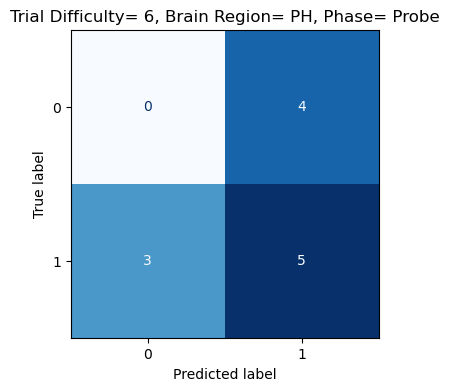

In [289]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test, y_pred are your true/predicted labels
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Trial Difficulty= 6, Brain Region= PH, Phase= Probe")
plt.show()

# Chunk 8: Visualize Feature Weights

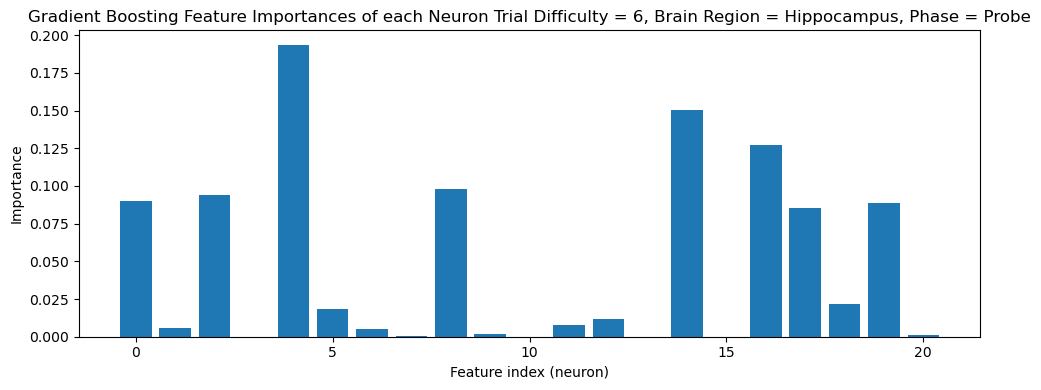

In [115]:
importances = best_model.feature_importances_

plt.figure(figsize=(10, 4))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index (neuron)")
plt.ylabel("Importance")
plt.title("Gradient Boosting Feature Importances of each Neuron Trial Difficulty = 6, Brain Region = Hippocampus, Phase = Probe")
plt.tight_layout()
plt.show()
